Q1. **Image Reconstruction** - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates $(X, Y)$ to the pixel colors $(R, G, B)$. Here, $(X, Y)$ represents the coordinates of the pixels, and $(R, G, B)$ represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. **[1.5 Mark]**

**Answer: Loading environment and image:**

Boy.jpg exists
torch.Size([3, 1281, 1920])


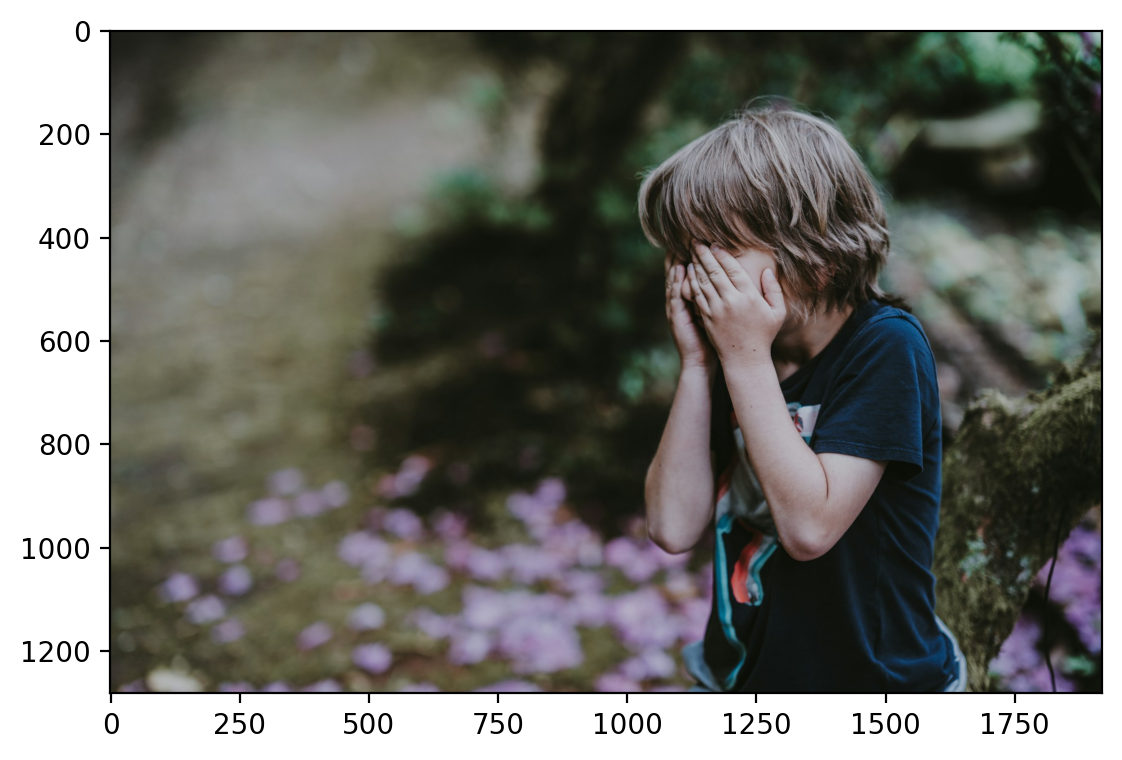

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


if os.path.exists('Boy.jpg'):
    print('Boy.jpg exists')

# Read in a image from torchvision
img = torchvision.io.read_image("Boy.jpg")
print(img.shape)
#Show image
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

**Reshaping the image and converting pixels to a 2-D array**

In [2]:
from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled


(3, 1281, 1920)


tensor([[[0.1478, 0.1429, 0.1379,  ..., 0.7882, 0.7833, 0.7783],
         [0.1429, 0.1429, 0.1379,  ..., 0.7931, 0.7833, 0.7833],
         [0.1379, 0.1379, 0.1429,  ..., 0.7931, 0.7833, 0.7783],
         ...,
         [0.3005, 0.3005, 0.2906,  ..., 0.0788, 0.0788, 0.0788],
         [0.3054, 0.3054, 0.3054,  ..., 0.0788, 0.0788, 0.0788],
         [0.3399, 0.3350, 0.3300,  ..., 0.0788, 0.0788, 0.0788]],

        [[0.1527, 0.1478, 0.1429,  ..., 0.9064, 0.9015, 0.8966],
         [0.1478, 0.1478, 0.1429,  ..., 0.9113, 0.9015, 0.9015],
         [0.1429, 0.1429, 0.1478,  ..., 0.9113, 0.9113, 0.9064],
         ...,
         [0.2562, 0.2562, 0.2562,  ..., 0.0936, 0.0936, 0.0936],
         [0.2611, 0.2611, 0.2611,  ..., 0.0936, 0.0936, 0.0936],
         [0.2857, 0.2808, 0.2709,  ..., 0.0936, 0.0936, 0.0936]],

        [[0.1232, 0.1182, 0.1133,  ..., 0.9064, 0.9015, 0.8966],
         [0.1182, 0.1182, 0.1133,  ..., 0.9113, 0.9015, 0.9015],
         [0.1133, 0.1133, 0.1182,  ..., 0.9113, 0.9064, 0.

**Now we have to crop the image so as to reduce computation time and memory allocation to cpu**

3 150 150


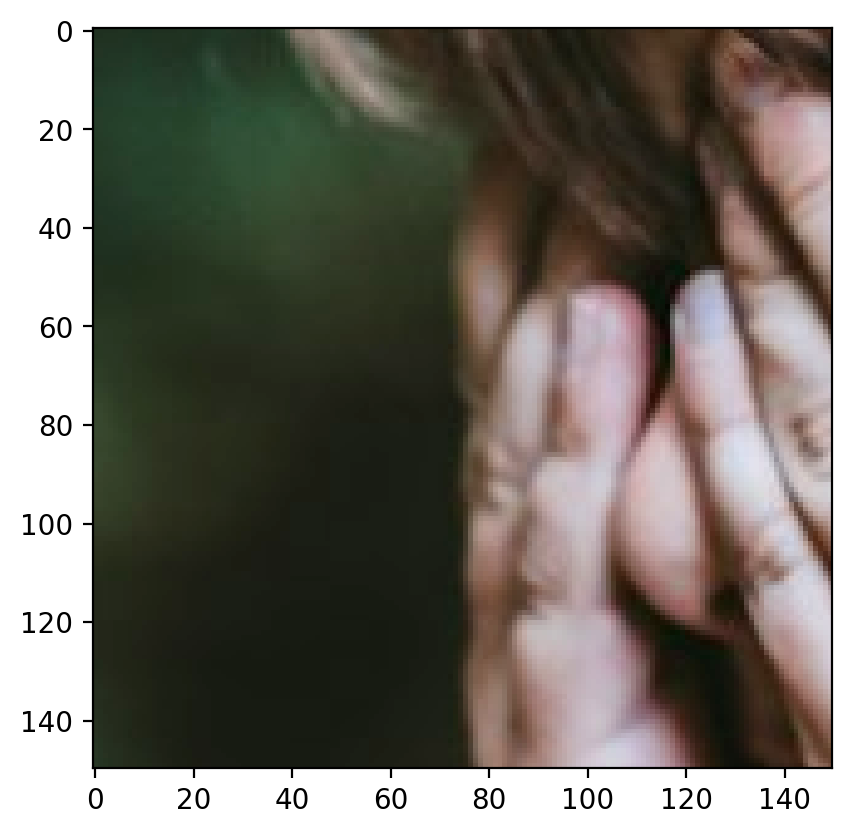

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 400, 1000, 150, 150)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

**Creating Coordinate map**

In [11]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
Boy_X, Boy_Y = create_coordinate_map(crop)

print(Boy_X.shape, Boy_Y.shape)

torch.Size([22500, 2]) torch.Size([22500, 3])


**Scaling the created X label(Boy_X) and defining the Linear Model**

In [12]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Boy_X.cpu())

# Scale the X coordinates
Boy_X_scaled = scaler_X.transform(Boy_X.cpu())

# Move the scaled X coordinates to the GPU
Boy_X_scaled = torch.tensor(Boy_X_scaled).to(device)

# Set to dtype float32
Boy_X_scaled = Boy_X_scaled.float()

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

**Train The Model**

In [13]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
train(net, 0.01, Boy_X_scaled, Boy_Y, 1000)


Epoch 0 loss: 0.300756
Epoch 100 loss: 0.037622
Epoch 200 loss: 0.035800
Epoch 300 loss: 0.035800
Epoch 400 loss: 0.035800
Epoch 500 loss: 0.035800
Epoch 600 loss: 0.035800
Epoch 700 loss: 0.035800
Epoch 800 loss: 0.035800
Epoch 900 loss: 0.035800


0.03579983487725258

**Plot of Reconstructed Image and Defining RMSE and PSNR**

RMSE: 0.18920844081309118
PSNR: 14.461189862196228 dB


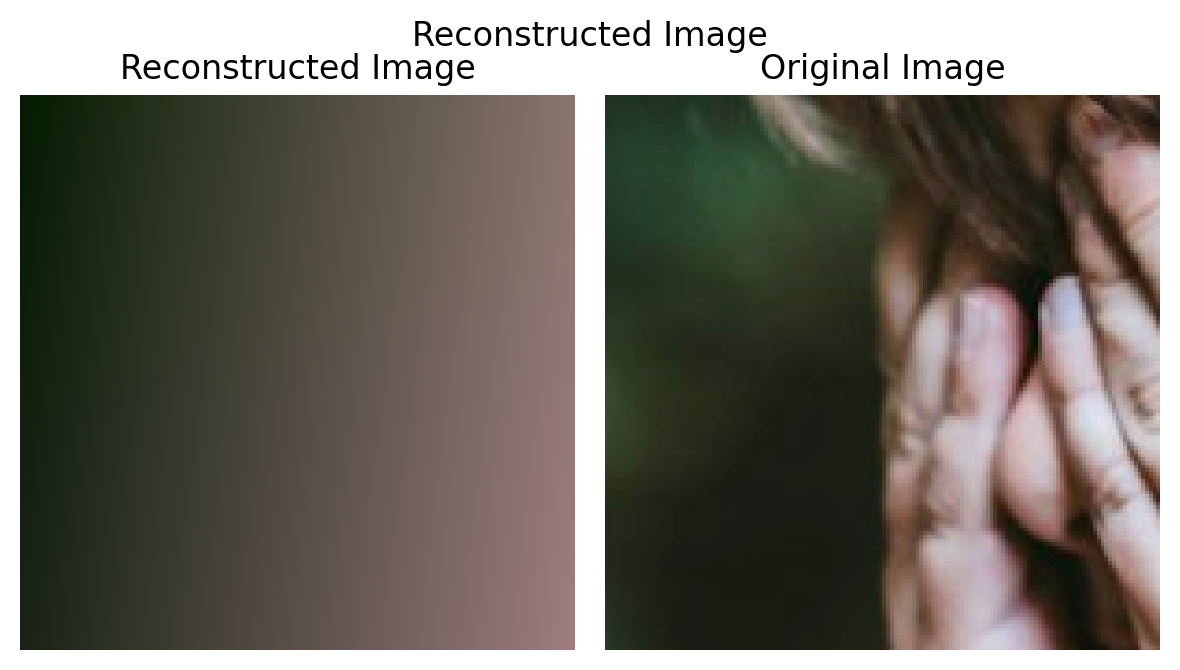

In [14]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        # print(outputs.shape)
        outputs = outputs.reshape(height, width,num_channels )
        # outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    # Calculate RMSE and PSNR
    def calculate_rmse(outputs, original):
        mse = torch.mean((outputs - original) ** 2).item()
        rmse = np.sqrt(mse)
        return rmse
    def calculate_psnr(output, original):
        mse = torch.mean((output - original) ** 2).item()
        if mse == 0:
            return float('inf')  # If MSE is 0, PSNR is infinite
        max_pixel_value = 1.0 if output.max() <= 1 else 255.0  # Assuming pixel values are normalized
        psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
        return psnr


    #  images are tensors in the format (C, H, W) and have been moved to CPU
    output_image = outputs.cpu()
    original_image = original_img.cpu().permute(1, 2, 0)  # Convert to (H, W, C) format if needed

    # If needed, normalize to range [0, 1] for PSNR calculation
    output_image = torch.clamp(output_image, 0, 1)
    original_image = torch.clamp(original_image, 0, 1)


    # Calculate RMSE and PSNR
    rmse_value = calculate_rmse(output_image, original_image)
    psnr_value = calculate_psnr(output_image, original_image)

    print(f"RMSE: {rmse_value}")
    print(f"PSNR: {psnr_value} dB")
    
plot_reconstructed_and_original_image(crop, net, Boy_X_scaled, title="Reconstructed Image")

**Trying with polynomial features**

Epoch 0 loss: 0.134359
Epoch 100 loss: 0.023053
Epoch 200 loss: 0.019494
Epoch 300 loss: 0.017561
Epoch 400 loss: 0.016286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15389228..0.90967274].


RMSE: 0.12398944845800301
PSNR: 18.132305437310855 dB


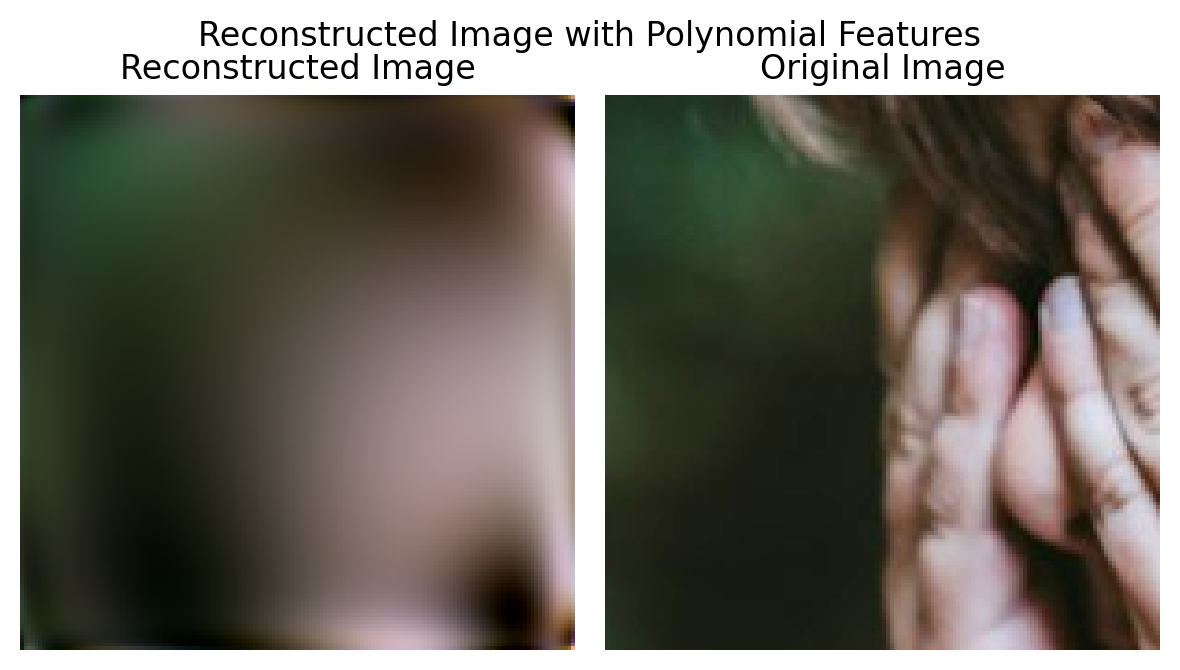

In [15]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)
dog_X_scaled_poly = poly_features(Boy_X_scaled, 50)
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, Boy_Y.shape, Boy_Y.dtype
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, Boy_Y, 500)
plot_reconstructed_and_original_image(crop, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")


**Using RFF Features**

torch.Size([22500, 37500])
Epoch 0 loss: 0.136991
Epoch 100 loss: 0.027695
Epoch 200 loss: 0.017975
Epoch 300 loss: 0.012125
Epoch 400 loss: 0.008228


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10756689..0.84408474].


RMSE: 0.07446119450751101
PSNR: 22.561400022073308 dB


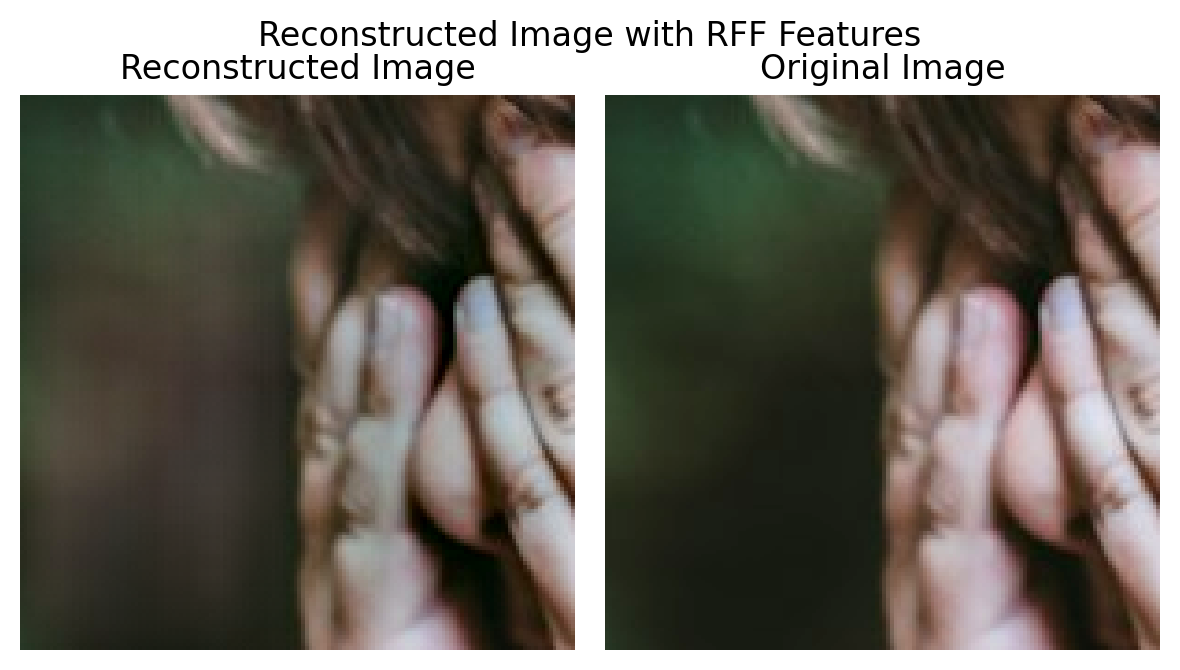

In [19]:

# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
X_rff = create_rff_features(Boy_X_scaled, 37500, 0.008)
print(X_rff.shape)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, Boy_Y, 500)

plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")